In [31]:
from datetime import datetime, timedelta
import geopandas as gpd
import json
import pandas as pd
import mapclassify
import matplotlib.pyplot as plt
import numpy as np
import os
import requests
import re
from io import StringIO
import warnings
from shapely import wkt
from shapely.geometry import Point

warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option("display.max_rows", None)
np.set_printoptions(threshold=np.inf)

In [32]:
# Read the data
blv_file_path = os.path.join('Data', 'blind_low_vision_rates.csv')  # construct the file path
blv_df = pd.read_csv(blv_file_path)
print(len(blv_df))
print(blv_df.dtypes)
blv_df.head(2)


3531
geometry             object
locationdesc         object
locationdesc.1       object
age                  object
geographiclevel      object
locationdesc.2       object
locationdesc.3       object
blv_rate            float64
blv_standardized    float64
dtype: object


,geometry,locationdesc,locationdesc.1,age,geographiclevel,locationdesc.2,locationdesc.3,blv_rate,blv_standardized
0,POINT (-66.93 17.97),Guanica Municipality,Guanica Municipality,All ages,County,Guanica Municipality,Guanica Municipality,24.53,9.178423
1,POINT (-66.96 18.08),Sabana Grande Municipality,Sabana Grande Municipality,All ages,County,Sabana Grande Municipality,Sabana Grande Municipality,18.93,6.854772


In [34]:
# Rename united states 
blv_df.loc[blv_df['locationdesc'] == 'National', 'locationdesc'] = 'United States'


In [35]:
illness_file_path = os.path.join('Data', 'illness_rates_USA.csv')  # construct the file path
illness_df = pd.read_csv(illness_file_path)
illness_df = pd.melt(illness_df, id_vars='locationdesc')
illness_df.rename(columns={"variable": "health_ques", "value": "health_resp"}, inplace=True)
illness_df['geographiclevel'] = illness_df.apply(lambda x: 'National' if x['locationdesc'] == 'United States' else 'State', axis=1)

print(len(illness_df))
print(illness_df.dtypes)
illness_df.head(2)

660
locationdesc        object
health_ques         object
health_resp        float64
geographiclevel     object
dtype: object


,locationdesc,health_ques,health_resp,geographiclevel
0,Alabama,Cardiovascular Disease:Awareness of high blood...,39.4,State
1,Alaska,Cardiovascular Disease:Awareness of high blood...,32.8,State


In [36]:
illness_df.locationdesc.unique()

array(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California',
       'Colorado', 'Connecticut', 'Delaware', 'District of Columbia',
       'Florida', 'Georgia', 'Guam', 'Hawaii', 'Idaho', 'Illinois',
       'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine',
       'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
       'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'Puerto Rico', 'Rhode Island', 'South Carolina',
       'South Dakota', 'Tennessee', 'Texas', 'United States', 'Utah',
       'Vermont', 'Virgin Islands', 'Virginia', 'Washington',
       'West Virginia', 'Wisconsin', 'Wyoming'], dtype=object)

In [37]:
len(illness_df)

660

In [38]:
illness_df.geographiclevel.unique()

array(['State', 'National'], dtype=object)

In [68]:
# filter blv_df
blv_filtered = blv_df[blv_df['age'] == 'All ages']

# perform left join on the filtered data
joined_filtered = pd.merge(blv_filtered, illness_df, how='left', on=['locationdesc','geographiclevel'])

# concatenate joined data with the remaining rows of blv_df
blv_illness_df = pd.concat([joined_filtered, blv_df[~(blv_df['age'] == 'All ages')]])

blv_illness_df = blv_illness_df.drop(['locationdesc.1', 'locationdesc.2','locationdesc.3'], axis=1)
blv_illness_df.head(5)

,geometry,locationdesc,age,geographiclevel,blv_rate,blv_standardized,health_ques,health_resp
0,POINT (-66.93 17.97),Guanica Municipality,All ages,County,24.53,9.178423,NaN,NaN
1,POINT (-66.96 18.08),Sabana Grande Municipality,All ages,County,18.93,6.854772,NaN,NaN
2,POINT (-66.36 18.08),Coamo Municipality,All ages,County,16.72,5.937759,NaN,NaN
3,POINT (-156.979972 21.188495),Kalawao County,All ages,County,16.39,5.800830,NaN,NaN
4,POINT (-66.86 18.03),Yauco Municipality,All ages,County,15.95,5.618257,NaN,NaN


In [69]:
blv_illness_national_df = blv_illness_df[blv_illness_df['geographiclevel']=='National']
print(len(blv_illness_national_df))

17


In [70]:
blv_filtered[blv_filtered['geographiclevel']=='National'].head(10)

,geometry,locationdesc,locationdesc.1,age,geographiclevel,locationdesc.2,locationdesc.3,blv_rate,blv_standardized
2266,NaN,United States,National,All ages,National,National,National,2.41,0.0


In [71]:
illness_df[illness_df['geographiclevel']=='National'].head(2)

,locationdesc,health_ques,health_resp,geographiclevel
46,United States,Cardiovascular Disease:Awareness of high blood...,29.6,National
101,United States,Cardiovascular Disease:High cholesterol preval...,29.1,National


In [74]:
blv_illness_df['geometry'] = blv_illness_df['geometry'].astype(str)

# Fill in the national points
blv_illness_df.loc[blv_illness_df['geographiclevel'] == 'National', 'geometry'] = str(Point(-99.8281, 37.6493))

blv_illness_df[blv_illness_df['geographiclevel']=='National'].head(2)

,geometry,locationdesc,age,geographiclevel,blv_rate,blv_standardized,health_ques,health_resp
2239,POINT (-99.8281 37.6493),United States,All ages,National,2.41,0.0,Cardiovascular Disease:Awareness of high blood...,29.6
2240,POINT (-99.8281 37.6493),United States,All ages,National,2.41,0.0,Cardiovascular Disease:High cholesterol preval...,29.1


In [75]:
# Remove any non-WKT strings from the 'geometry' column
def is_wkt(string):
    return bool(re.match(r'^\s*POINT\s*\(', string))

blv_illness_df = blv_illness_df[blv_illness_df['geometry'].apply(is_wkt)]
print(len(blv_illness_df))


4092


In [76]:
blv_illness_df['geometry'] = blv_illness_df['geometry'].apply(wkt.loads)
blv_illness_df = gpd.GeoDataFrame(blv_illness_df, geometry='geometry')
blv_illness_df = blv_illness_df.set_crs("EPSG:4326")


# Extract lat and lon columns from the geometry column
blv_illness_df['lon'] = blv_illness_df['geometry'].x
blv_illness_df['lat'] = blv_illness_df['geometry'].y

In [77]:
parent_dir = os.path.abspath('..')  # get the absolute path of the parent directory
file_path = os.path.join('Data', 'blv_illness_rates_USA.csv')  # construct the file path
blv_illness_df.to_csv(file_path, index=False)

In [79]:
blv_illness_df[(blv_illness_df['health_resp']>=0) & (blv_illness_df['geographiclevel']=='National')]

,geometry,locationdesc,age,geographiclevel,blv_rate,blv_standardized,health_ques,health_resp,lon,lat
2239,POINT (-99.82810 37.64930),United States,All ages,National,2.41,0.0,Cardiovascular Disease:Awareness of high blood...,29.6,-99.8281,37.6493
2240,POINT (-99.82810 37.64930),United States,All ages,National,2.41,0.0,Cardiovascular Disease:High cholesterol preval...,29.1,-99.8281,37.6493
2241,POINT (-99.82810 37.64930),United States,All ages,National,2.41,0.0,Cardiovascular Disease:Mortality from cerebrov...,37.0,-99.8281,37.6493
2242,POINT (-99.82810 37.64930),United States,All ages,National,2.41,0.0,Diabetes:Mortality with diabetic ketoacidosis ...,1.5,-99.8281,37.6493
2243,POINT (-99.82810 37.64930),United States,All ages,National,2.41,0.0,Diabetes:Prevalence of diagnosed diabetes amon...,9.4,-99.8281,37.6493
2244,POINT (-99.82810 37.64930),United States,All ages,National,2.41,0.0,Diabetes:Prevalence of high blood pressure amo...,59.3,-99.8281,37.6493
2245,POINT (-99.82810 37.64930),United States,All ages,National,2.41,0.0,Diabetes:Prevalence of high cholesterol among ...,51.3,-99.8281,37.6493
2246,POINT (-99.82810 37.64930),United States,All ages,National,2.41,0.0,"Nutrition, Physical Activity, and Weight Statu...",32.1,-99.8281,37.6493
2247,POINT (-99.82810 37.64930),United States,All ages,National,2.41,0.0,Overarching Conditions:Current lack of health ...,13.9,-99.8281,37.6493
2248,POINT (-99.82810 37.64930),United States,All ages,National,2.41,0.0,Overarching Conditions:Fair or poor self-rated...,17.3,-99.8281,37.6493


# Load geospatial files 

### County

In [80]:
county_shapefile_path = os.path.join('Data', 'geoms', 'cb_2021_us_county_500k', 'cb_2021_us_county_500k.shp')
county_gdf = gpd.read_file(county_shapefile_path)
print(len(county_gdf))

county_gdf = county_gdf.rename(columns={'NAMELSAD': 'locationdesc', 'STATE_NAME': 'state'})
county_gdf = county_gdf[['geometry','state','GEOID']]

county_gdf.head()

3234


,geometry,state,GEOID
0,"POLYGON ((-96.96095 39.28670, -96.96106 39.288...",Kansas,20161
1,"POLYGON ((-94.47167 40.81255, -94.47166 40.819...",Iowa,19159
2,"POLYGON ((-109.79867 45.16734, -109.68779 45.1...",Montana,30009
3,"POLYGON ((-111.63452 42.57034, -111.63010 42.5...",Idaho,16007
4,"POLYGON ((-92.08384 44.41200, -92.08310 44.414...",Wisconsin,55011


In [81]:
# perform the spatial join with blv_illness_df
county_joined_gdf = gpd.sjoin(county_gdf, blv_illness_df[blv_illness_df['geographiclevel']=='County'], op='intersects',how='left')
print(len(county_joined_gdf))
county_joined_gdf.head(5)


3245


,geometry,state,GEOID,index_right,locationdesc,age,geographiclevel,blv_rate,blv_standardized,health_ques,health_resp,lon,lat
0,"POLYGON ((-96.96095 39.28670, -96.96106 39.288...",Kansas,20161,2220.0,Riley County,All ages,County,2.43,0.008299,NaN,NaN,-96.633015,39.189473
1,"POLYGON ((-94.47167 40.81255, -94.47166 40.819...",Iowa,19159,2824.0,Ringgold County,All ages,County,2.08,-0.136929,NaN,NaN,-94.238520,40.733763
2,"POLYGON ((-109.79867 45.16734, -109.68779 45.1...",Montana,30009,1795.0,Carbon County,All ages,County,2.70,0.120332,NaN,NaN,-109.084478,45.321484
3,"POLYGON ((-111.63452 42.57034, -111.63010 42.5...",Idaho,16007,1351.0,Bear Lake County,All ages,County,3.12,0.294606,NaN,NaN,-111.341632,42.306336
4,"POLYGON ((-92.08384 44.41200, -92.08310 44.414...",Wisconsin,55011,3426.0,Buffalo County,All ages,County,1.66,-0.311203,NaN,NaN,-91.743927,44.379071


### State

In [82]:
state_shapefile_path = os.path.join('Data', 'geoms', 'cb_2021_us_state_500k', 'cb_2021_us_state_500k.shp')
state_gdf = gpd.read_file(state_shapefile_path)
print(len(state_gdf))

state_gdf = state_gdf.rename(columns={'NAME': 'locationdesc'})
state_gdf = state_gdf[['geometry','GEOID']]

state_gdf.head()

56


,geometry,GEOID
0,"POLYGON ((-111.05456 45.00095, -111.04507 45.0...",56
1,"MULTIPOLYGON (((179.48246 51.98283, 179.48657 ...",02
2,"MULTIPOLYGON (((-76.05015 37.98691, -76.04998 ...",24
3,"MULTIPOLYGON (((-168.14582 -14.54791, -168.145...",60
4,"POLYGON ((-94.61792 36.49941, -94.61765 36.499...",05


In [83]:
# perform the spatial join with blv_illness_df
state_joined_gdf = gpd.sjoin(state_gdf, blv_illness_df[blv_illness_df['geographiclevel']=='State'], op='intersects',how='left')
print(len(state_joined_gdf))
state_joined_gdf.head(5)


861


,geometry,GEOID,index_right,locationdesc,age,geographiclevel,blv_rate,blv_standardized,health_ques,health_resp,lon,lat
0,"POLYGON ((-111.05456 45.00095, -111.04507 45.0...",56,1403.0,Wyoming,All ages,State,3.07,0.273859,Cardiovascular Disease:Mortality from cerebrov...,31.7,-108.10983,43.235541
0,"POLYGON ((-111.05456 45.00095, -111.04507 45.0...",56,145.0,Wyoming,0-17 years,State,1.28,1.706667,NaN,NaN,-108.10983,43.235541
0,"POLYGON ((-111.05456 45.00095, -111.04507 45.0...",56,319.0,Wyoming,65-84 years,State,6.18,1.216535,NaN,NaN,-108.10983,43.235541
0,"POLYGON ((-111.05456 45.00095, -111.04507 45.0...",56,1406.0,Wyoming,All ages,State,3.07,0.273859,Diabetes:Prevalence of high blood pressure amo...,53.0,-108.10983,43.235541
0,"POLYGON ((-111.05456 45.00095, -111.04507 45.0...",56,1402.0,Wyoming,All ages,State,3.07,0.273859,Cardiovascular Disease:High cholesterol preval...,25.2,-108.10983,43.235541


<AxesSubplot:>

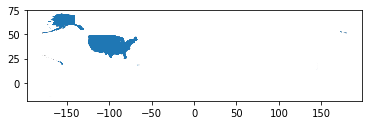

In [84]:
state_joined_gdf.plot()

### National

In [85]:
nation_shapefile_path = os.path.join('Data', 'geoms', 'cb_2021_us_nation_5m', 'cb_2021_us_nation_5m.shp')
nation_gdf = gpd.read_file(nation_shapefile_path)
print(len(nation_gdf))

nation_gdf = nation_gdf.rename(columns={'NAME': 'locationdesc'})
nation_gdf = nation_gdf[['geometry','locationdesc','GEOID']]

nation_gdf = nation_gdf.to_crs(epsg=4326)

nation_gdf.head()

1


,geometry,locationdesc,GEOID
0,"MULTIPOLYGON (((179.48246 51.98284, 179.48657 ...",United States,US


<AxesSubplot:>

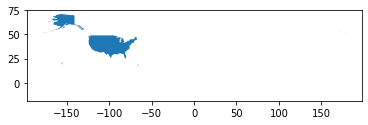

In [86]:
nation_gdf.plot()

In [87]:
# Create a point geometry at the centroid of the United States
blv_illness_national_df['geometry'] = Point(-98.5795, 39.8283)
blv_illness_national_df['geometry'] = blv_illness_national_df['geometry'].astype(str)
blv_illness_national_df['geometry'] = blv_illness_national_df['geometry'].apply(wkt.loads)
blv_illness_national_gdf = gpd.GeoDataFrame(blv_illness_national_df, geometry='geometry')
blv_illness_national_gdf = blv_illness_national_gdf.set_crs("EPSG:4326")
blv_illness_national_gdf.head(10)


,geometry,locationdesc,age,geographiclevel,blv_rate,blv_standardized,health_ques,health_resp
2239,POINT (-98.57950 39.82830),United States,All ages,National,2.41,0.0,Cardiovascular Disease:Awareness of high blood...,29.6
2240,POINT (-98.57950 39.82830),United States,All ages,National,2.41,0.0,Cardiovascular Disease:High cholesterol preval...,29.1
2241,POINT (-98.57950 39.82830),United States,All ages,National,2.41,0.0,Cardiovascular Disease:Mortality from cerebrov...,37.0
2242,POINT (-98.57950 39.82830),United States,All ages,National,2.41,0.0,Diabetes:Mortality with diabetic ketoacidosis ...,1.5
2243,POINT (-98.57950 39.82830),United States,All ages,National,2.41,0.0,Diabetes:Prevalence of diagnosed diabetes amon...,9.4
2244,POINT (-98.57950 39.82830),United States,All ages,National,2.41,0.0,Diabetes:Prevalence of high blood pressure amo...,59.3
2245,POINT (-98.57950 39.82830),United States,All ages,National,2.41,0.0,Diabetes:Prevalence of high cholesterol among ...,51.3
2246,POINT (-98.57950 39.82830),United States,All ages,National,2.41,0.0,"Nutrition, Physical Activity, and Weight Statu...",32.1
2247,POINT (-98.57950 39.82830),United States,All ages,National,2.41,0.0,Overarching Conditions:Current lack of health ...,13.9
2248,POINT (-98.57950 39.82830),United States,All ages,National,2.41,0.0,Overarching Conditions:Fair or poor self-rated...,17.3


In [88]:
# perform the spatial join with blv_illness_df
national_joined_df = gpd.sjoin(nation_gdf, blv_illness_national_gdf, op='intersects', how='left')
print(len(national_joined_df))
national_joined_df.head(5)

17


,geometry,locationdesc_left,GEOID,index_right,locationdesc_right,age,geographiclevel,blv_rate,blv_standardized,health_ques,health_resp
0,"MULTIPOLYGON (((179.48246 51.98284, 179.48657 ...",United States,US,2239,United States,All ages,National,2.41,0.0,Cardiovascular Disease:Awareness of high blood...,29.6
0,"MULTIPOLYGON (((179.48246 51.98284, 179.48657 ...",United States,US,2240,United States,All ages,National,2.41,0.0,Cardiovascular Disease:High cholesterol preval...,29.1
0,"MULTIPOLYGON (((179.48246 51.98284, 179.48657 ...",United States,US,2241,United States,All ages,National,2.41,0.0,Cardiovascular Disease:Mortality from cerebrov...,37.0
0,"MULTIPOLYGON (((179.48246 51.98284, 179.48657 ...",United States,US,2242,United States,All ages,National,2.41,0.0,Diabetes:Mortality with diabetic ketoacidosis ...,1.5
0,"MULTIPOLYGON (((179.48246 51.98284, 179.48657 ...",United States,US,2243,United States,All ages,National,2.41,0.0,Diabetes:Prevalence of diagnosed diabetes amon...,9.4


In [ ]:
national_joined_df[national_joined_df['']]

# Merge all geometries

<AxesSubplot:>

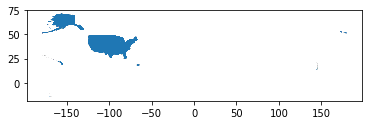

In [89]:
shapes = [county_joined_gdf, state_joined_gdf, national_joined_df]
shapes_gdf = gpd.GeoDataFrame(pd.concat(shapes, ignore_index=True), crs=county_gdf.crs)
shapes_gdf = shapes_gdf.drop(['locationdesc_left', 'locationdesc_left'], axis=1)
shapes_gdf.plot()

In [90]:
# Create columns for county, state
shapes_gdf['county'] = shapes_gdf.apply(lambda x: x['locationdesc'] if x['geographiclevel']=='County' else None,axis=1 )
shapes_gdf['state'] = shapes_gdf.apply(lambda x: x['locationdesc'] if x['geographiclevel']=='State' else x['state'],axis=1 )



In [91]:
# Add new column for question group and remove the group from the question 

def fix_question(question):
    q_split= question.split(':')
    q_type, q = q_split[0], q_split[1]
    if q_type == 'Diabetes':
        return ('Diabeted',q)
    if q_type == 'Cardiovascualar Disease':
        return ('Diabeted',q)   
    return ('Overarching Condition',q)

shapes_gdf['h_group','h_question'] = shapes_gdf.apply(lambda: x: fix_question(x), axis=1)
    
    

In [99]:
# Add new column for question group and remove the group from the question 
def fix_question(question):
    if pd.isnull(question): # Use pd.isnull() to check for missing values
        return ('n/a', 'n/a')
    q_split = question.split(':')
    q_type, q = q_split[0], q_split[1].strip() # remove leading/trailing white space
    if q_type == 'Diabetes':
        return ('Diabetes', q)
    if q_type == 'Cardiovascular Disease': # fix spelling error in disease name
        return ('Cardiovascular Disease', q)
    return ('Overarching Condition', q)

# Create new columns for the question group and question text
shapes_gdf[['h_group', 'h_question']] = shapes_gdf['health_ques'].apply(fix_question).apply(pd.Series)
shapes_gdf.h_question.value_counts()

n/a                                                                                        3511
Mortality from cerebrovascular disease (stroke)                                              51
Prevalence of high blood pressure among adults aged >= 18 years with diagnosed diabetes      51
High cholesterol prevalence among adults aged >= 18 years                                    51
Awareness of high blood pressure among adults aged >= 18 years                               51
Prevalence of diagnosed diabetes among adults aged >= 18 years                               51
Prevalence of high cholesterol among adults aged >= 18 years with diagnosed diabetes         51
Obesity among adults aged >= 18 years                                                        51
Current lack of health insurance among adults aged 18-64 years                               51
Fair or poor self-rated health status among adults aged >= 18 years                          51
Life expectancy at birth                

In [100]:
shapes_gdf.to_file('Data/polygonal_blv_illness_gdf.shp')
print(len(shapes_gdf))
shapes_gdf.head(2)

4123


,geometry,state,GEOID,index_right,locationdesc,age,geographiclevel,blv_rate,blv_standardized,health_ques,health_resp,lon,lat,locationdesc_right,county,h_group,h_question
0,"POLYGON ((-96.96095 39.28670, -96.96106 39.288...",Kansas,20161,2220.0,Riley County,All ages,County,2.43,0.008299,NaN,NaN,-96.633015,39.189473,NaN,Riley County,n/a,n/a
1,"POLYGON ((-94.47167 40.81255, -94.47166 40.819...",Iowa,19159,2824.0,Ringgold County,All ages,County,2.08,-0.136929,NaN,NaN,-94.238520,40.733763,NaN,Ringgold County,n/a,n/a


In [93]:

cols = blv_illness_df.columns[1:] # drop the geometry 

print(cols)

polygonal_blv_illness_df =  pd.merge(blv_illness_df[cols], shapes_gdf, on='locationdesc', how='left')
polygonal_blv_illness_gdf = gpd.GeoDataFrame(polygonal_blv_illness_df, geometry='geometry')

joined_df = joined_df.set_index('index_right')
joined_df.reset_index()
merged_df = polygonal_blv_illness_gdf.merge(joined_df[['geometry','state']], left_index=True, right_index=True, how='left')

Index(['locationdesc', 'age', 'geographiclevel', 'blv_rate',
       'blv_standardized', 'health_ques', 'health_resp', 'lon', 'lat'],
      dtype='object')


NameError: name 'joined_df' is not defined

In [ ]:
polygonal_blv_illness_gdf.to_file('Data/polygonal_blv_illness_gdf.shp')

In [ ]:

joined_df.head()

In [ ]:
len(polygonal_blv_illness_gdf)

In [ ]:
merged_df.head()

In [ ]:
# Merge columns geometry_x and geometry_y into a new column 'geometry'
merged_df['geometry'] = merged_df['geometry_x'].combine_first(merged_df['geometry_y'])

# Drop columns geometry_x and geometry_y
# merged_df = merged_df.drop(columns=['geometry_x', 'geometry_y'])

merged_df.head(500)

In [ ]:
# Create columns for county, state
merged_df['county'] = merged_df.apply(lambda x: x['locationdesc'] if x['geographiclevel']=='County' else None,axis=1 )
merged_df['state'] = merged_df.apply(lambda x: x['locationdesc'] if x['geographiclevel']=='State' else x['state'],axis=1 )




In [ ]:
merged_df.head()

In [ ]:
merged_gdf = gpd.GeoDataFrame(merged_df, geometry='geometry')


In [ ]:
merged_gdf[merged_gdf['geographiclevel']=='County'].plot(figsize=(150,150))

In [ ]:
merged_gdf = merged_gdf.dropna(subset=['geometry'])

In [ ]:
#merged_gdf['geometry'] = merged_gdf['geometry'].astype(str)


In [ ]:
# check which geometries are valid
valid_mask = merged_gdf['geometry'].is_valid
print(valid_mask)

# buffer invalid geometries by 0 distance to make them valid
merged_gdf.loc[~valid_mask, 'geometry'] = merged_gdf.loc[~valid_mask, 'geometry'].buffer(0)

# check which geometries are valid after buffering
valid_mask = merged_gdf['geometry'].is_valid
#print(valid_mask)

# drop rows with invalid geometries
merged_gdf = merged_gdf[valid_mask]


In [ ]:
merged_gdf.to_file('Data/blv_illness_rates_USA.shp')

In [ ]:
print(len(merged_gdf))
merged_gdf.head(100)

# Attempts to use altair

In [ ]:
import pandas as pd
import altair as alt

import geopandas as gpd


# Load your DataFrame (assuming it's already loaded as 'blv_illness_df')
df = blv_illness_df.dropna(subset=['geometry','blv_rate'])
df = df[(df['geographiclevel']=='State') & (df['age']=='All ages') & ~(df['locationdesc']=='District Of Columbia')]
df['geometry'] = df['geometry'].astype(str)

# Remove any non-WKT strings from the 'geometry' column
def is_wkt(string):
    return bool(re.match(r'^\s*POINT\s*\(', string))

df = df[df['geometry'].apply(is_wkt)]
print(len(df))

df['geometry'] = df['geometry'].apply(wkt.loads)
df = gpd.GeoDataFrame(df, geometry='geometry')
df = df.set_crs("EPSG:4326")


# Extract lat and lon columns from the geometry column
df['lon'] = df['geometry'].x
df['lat'] = df['geometry'].y

# Define the base chart with hexagonal binning
base = alt.Chart(df).mark_geoshape().encode(
    longitude='lon:Q',
    latitude='lat:Q',
    color=alt.Color('mean(blv_rate):Q', title='BLV Standardized'),
    tooltip=[
        alt.Tooltip('lon', title='Longitude'),
        alt.Tooltip('lat', title='Latitude'),
        alt.Tooltip('mean(blv_rate)', title='BLV Standardized')
    ]
).properties(
    width=600,
    height=400
).project("identity")

# Add interactivity to the chart
interactive_hex_map = base.interactive()

# Display the interactive hex map
interactive_hex_map


In [ ]:
import pandas as pd
import folium
from shapely import wkt
import geopandas as gpd
import re
from folium.plugins import HeatMap

# Load your DataFrame (assuming it's already loaded as 'blv_illness_df')
df = blv_illness_df.dropna(subset=['geometry'])
df = df[(df['geographiclevel']=='State') & (df['age']=='All ages')]
df['geometry'] = df['geometry'].astype(str)

# Remove any non-WKT strings from the 'geometry' column
def is_wkt(string):
    return bool(re.match(r'^\s*POINT\s*\(', string))

df = df[df['geometry'].apply(is_wkt)]
print(len(df))

df['geometry'] = df['geometry'].apply(wkt.loads)
df = gpd.GeoDataFrame(df, geometry='geometry')

# Extract lat and lon columns from the geometry column
df['lon'] = df['geometry'].x
df['lat'] = df['geometry'].y

# Create a base map
m = folium.Map(location=[df['lat'].mean(), df['lon'].mean()], zoom_start=4, control_scale=True)

# Add hexbin layer
HeatMap(data=df[['lat', 'lon', 'blv_rate']].values.tolist(), radius=15).add_to(m)

# Display the interactive hex map
m


In [ ]:
df.head(100)

In [ ]:
import pandas as pd
import geopandas as gpd
import altair as alt
from shapely import wkt
from shapely.geometry import Polygon
import h3

# Load your DataFrame (assuming it's already loaded as 'blv_illness_df')
df = blv_illness_df.dropna(subset=['geometry','blv_rate'])
df = df[(df['geographiclevel']=='State') & (df['age']=='All ages') & ~(df['locationdesc']=='District Of Columbia')]
df['geometry'] = df['geometry'].astype(str)

def is_wkt(string):
    return bool(re.match(r'^\s*POINT\s*\(', string))

df = df[df['geometry'].apply(is_wkt)]
print(len(df))

df['geometry'] = df['geometry'].apply(wkt.loads)
gdf = gpd.GeoDataFrame(df, geometry='geometry')

# Set the Coordinate Reference System (CRS) for your data
gdf = gdf.set_crs("EPSG:4326")


# Create hexbins
hex_resolution = 2
gdf['hex_id'] = gdf['geometry'].apply(lambda x: h3.geo_to_h3(x.y, x.x, hex_resolution))

# Aggregate data within each hexagon
hex_gdf_agg = gdf.groupby('hex_id').agg({'blv_rate': 'mean'}).reset_index()

# Create hexagon geometries
hex_gdf_agg['geometry'] = hex_gdf_agg['hex_id'].apply(lambda x: Polygon(h3.h3_to_geo_boundary(x, geo_json=True)))

# Convert to GeoDataFrame
hex_gdf_agg = gpd.GeoDataFrame(hex_gdf_agg, geometry='geometry', crs='EPSG:4326')

# Create an Altair chart
chart = alt.Chart(hex_gdf_agg).mark_geoshape().encode(
    color=alt.Color('blv_rate:Q', title='BLV Rate'),
    tooltip=[
        alt.Tooltip('hex_id:N', title='Hex ID'),
        alt.Tooltip('blv_rate:Q', title='BLV Rate'),
    ],
).project('identity')

# Add interactivity
interactive_chart = chart.interactive()

# Display the interactive chart
interactive_chart




In [ ]:
# Add interactivity
interactive_chart = chart.interactive()

# # Display the interactive chart
# interactive_chart

In [ ]:
interactive_chart.save('thing.html')

In [ ]:
valid_geometries = hex_gdf_agg['geometry'].apply(lambda geom: geom.is_valid)
all_geometries_valid = valid_geometries.all()

print("All geometries valid:", all_geometries_valid)


In [ ]:
hex_gdf_agg.plot()

In [ ]:
import mapclassify
import matplotlib.pyplot as plt

# Create a Natural Breaks classifier with 5 classes
classifier = mapclassify.NaturalBreaks.make(k=5)

# Classify the 'blv_rate' column using the classifier
hex_gdf_agg['blv_rate_class'] = hex_gdf_agg[['blv_rate']].apply(classifier)

# Plot the hexagons colored by the 'blv_rate_class' column
fig, ax = plt.subplots(figsize=(10, 10))
hex_gdf_agg.plot(column='blv_rate_class', cmap='viridis', linewidth=0.5, edgecolor='black', legend=True, ax=ax)

# Set the title and display the plot
ax.set_title('Hexagons Colored by BLV Rate (Natural Breaks)')
plt.show()


In [ ]:
import altair as alt
from vega_datasets import data
#alt.renderers.enable('notebook')

states = alt.topo_feature(data.us_10m.url, feature='states')
# US states background
background = alt.Chart(states).mark_geoshape(
    fill='lightgray',
    stroke='white'
).properties(
    projection={'type': 'albersUsa'},
    width=500,
    height=300)

background.interactive()

In [ ]:
pop = data.population_engineers_hurricanes()
print(len(pop))
pop.head()

In [ ]:
df.head()

In [ ]:
df = blv_illness_df.dropna(subset=['geometry','blv_rate'])
df = df[(df['geographiclevel']=='State') & (df['age']=='All ages') & ~(df['locationdesc']=='District Of Columbia')]


df = pd.merge(pop[['id','state']], 
              df[['locationdesc','blv_rate','blv_standardized']], 
              how='left', 
              left_on=['state'], 
              right_on='locationdesc')
print(len(df))

In [ ]:
import altair as alt
from vega_datasets import data

states = alt.topo_feature(data.us_10m.url, 'states')

# Add a single selection to enable pointer click
selection = alt.selection_single(fields=['locationdeic', 'blv_rate'], empty='none', on='click')

alt.Chart(states).mark_geoshape().encode(
    color=alt.condition(
        selection,
        alt.value('red'),  # Change the color of the selected state to red
        alt.Color('blv_rate:Q', scale=alt.Scale(scheme='blueorange'))
    ),
    tooltip=[
        alt.Tooltip('locationdesc:N', title='Location'),
        alt.Tooltip('blv_rate:Q', title='BLV Rate')
    ]
).transform_lookup(
    lookup='id',
    from_=alt.LookupData(df, 'id', list(df.columns))
).properties(
    width=800,
    height=400
).project(
    type='albersUsa'
).add_selection(
    selection
)



In [ ]:
import altair as alt
from vega_datasets import data

states = alt.topo_feature(data.us_10m.url, 'states')

# Create a dropdown menu
column_dropdown = alt.binding_select(options=['blv_rate', 'blv_standardized'], name='Statistic')
column_selection = alt.selection_single(fields=['Statistic'], bind=column_dropdown, init={'Statistic': 'blv_rate'})

alt.Chart(states).mark_geoshape().encode(
    color=alt.condition(column_selection, alt.datum[alt.binding('Statistic')], alt.value('lightgray'), scale=alt.Scale(scheme='blueorange')),
    tooltip=[
        alt.Tooltip('locationdesc:N', title='State'),
        alt.Tooltip('blv_rate:Q', title='BLV Rate'),
        alt.Tooltip('blv_standardized:Q', title='BLV Standardized')
    ]
).transform_lookup(
    lookup='id',
    from_=alt.LookupData(df, 'id', ['id', 'locationdesc', 'blv_rate', 'blv_standardized'])
).properties(
    width=800,
    height=400
).project(
    type='albersUsa'
).add_selection(
    column_selection
)



In [ ]:
print(alt.__version__)